# Individual Data Plots

In [1]:
import numpy as np
import xarray as xr
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
from scipy import stats
import csv

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1, 12 + 1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']

colors = prop_cycle.by_key()['color']
cc = prop_cycle.by_key()['color']

In [2]:
brokers = ['', '172.19.0.2', '172.19.0.3','172.19.0.4','172.19.0.5','172.19.0.6','172.19.0.7','172.19.0.8']
clients = ['172.19.0.9', '172.19.0.10']

filename = "../b1.csv"
csv_dir = "../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_sf/csv/"
num_brokers = 7
csv_files = []
plot_base_name = ""
output_dir = "./"

In [3]:
def save_plot(file_name):
    global output_dir
    plt.savefig(output_dir + file_name + ".png", dpi=300)
    return

In [4]:
def my_init(csv_dir):
    csv_files = []
    # configures csv_files
    for i in range(num_brokers):
        file = csv_dir+"b{}.csv".format(i+1)
        # print(file)
        csv_files.append(file)
    return csv_files

def parse_single_csv(filename):
    fields = []
    rows = []

    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)

        # extracting field names through first row
        fields = next(csvreader)

        for row in csvreader:
            rows.append({ 'time': float(row[0]), 'len': int(row[1]), 'src': row[2], 'dst': row[3] })
        print("[{}] Total no. of rows: {}".format(filename, csvreader.line_num))

    # printing the field names


    #  printing first 5 rows
    # print('\nFirst 5 rows are:\n')
    # print(' | '.join(field.ljust(20) for field in fields))
    # for row in rows[:5]:
        # parsing each column of a row
        # print(' | '.join(str(col).ljust(20) for col in row.values()))
    return (fields, rows)

# returns a list of [ (field, data), (field, data) ]  for each csv in @csv_files
def parse_num_csv(csv_files):
    result = []
    for file in csv_files:
        # print("parsing "+file)
        result.append(parse_single_csv(file))
    return result

In [5]:
def print_csv(field, data, all_data = 1):
    print(' | '.join(field.ljust(20) for field in fields))
    if(all_data):
        for row in data:
            print(' | '.join(str(col).ljust(20) for col in row.values()))
        return
    if(all_data > len(data)):
        all_data = len(data)
    
    for row in data[:all_data]:
            print(' | '.join(str(col).ljust(20) for col in row.values()))
    return

def print_data(data, all_data = 1):
    if(all_data):
        all_data = len(data)
    if(all_data > len(data)):
        all_data = len(data)
    
    for row in data[:all_data]:
            print(' | '.join(str(col).ljust(20) for col in row.values()))
    return

# returns true if @src matches ANY of the @filters
def check_in_multiple(src, filters):
    if(filters is None or len(filters) == 0):
        print("[ DEBUG ] not filters passed in")
        return False
    
    if(isinstance(src, str) and not src.strip()):
        return True
    
    for filter in filters:
        if(src == filter):
            # print("[ DEBUG ] {} matches {}".format(src, filter))
            return True
    return False

# filters data by excluding rows that matches @src_ip and @dst_ip
def my_filter(data, src_ip_filter, dst_ip_filter):
    filtered = []
    if data is None or len(data) == 0:
        print("[ ERROR ] no data given")
        return
    for row in data:
        condition_1 = check_in_multiple(row['src'], src_ip_filter)
        condition_2 = not check_in_multiple(row['dst'], dst_ip_filter)
        """
        print("[ DEBUG ] cond1={} cond2={}, src={}, dst={}, row={}".format(
            condition_1, condition_2, row['src'], row['dst'], row))
        """
        if(condition_1 and condition_2):
            filtered.append(row)
    return filtered

def round_time(data):
    if data is None or len(data) == 0:
        print("[ ERROR ] no data given")
        return None
    result = []
    for row in data:
        clone = row.copy()
        clone['time'] = int(clone['time'])
        result.append(clone)

    # print_data(result)
    return result

# for all data with same data[@key], do agg_func(@data[@value])
# this assumes the data is ALREADY SORTED in data[@key]
def aggregate_dup(data, key='time', value='len', agg_func=None):
    if data is None or len(data) == 0:
        print("[ ERROR ] no data given")
        return None
    if(not agg_func):
        agg_func = sum
    
    result = []
    temp = []
    curr_time = data[0][key]
    temp.append(data[0][value])
    
    for row in data[1:]:
        if(row[key] == curr_time):
            temp.append(row[value])
        else:
            # now we are at a new time, first compute the previous aggregates
            result.append({ 'time':curr_time, 'len': agg_func(temp) })
            # print("[ DEBUG ] summed to "+str({ 'rounded_time':curr_time, 'len': sum(temp) }))
            
            # reset the temp and update the new curr time pointer
            temp = []
            curr_time = row[key]
            temp.append(row[value])
    
    # computes the last
    result.append({ 'time':curr_time, 'len': agg_func(temp) })
    # print("[ DEBUG ] summed to "+str({ 'rounded_time':curr_time, 'len': agg_func(temp) }))
    return result

# works if @data is already sorted in key
def zero_fill(data, key='time', up_to = 125):
    result = []
    prev = data[0][key]
    if(prev > 0):
        # we need to pad backward in time
        missing = prev
        for i in range(missing):
                temp = data[0].copy()
                temp = dict.fromkeys(temp, 0)
                temp[key] = i
                result.append(temp)
    
    result.append(data[0])
    
    for curr in data[1:]:
        """
        if(curr[key] > up_to):
            break
        """
        missing = curr[key] - prev - 1
        if(missing > 0):
            # not continous, zero fill
            for i in range(missing):
                temp = curr.copy()
                temp = dict.fromkeys(temp, 0)
                temp[key] = prev + i + 1
                result.append(temp)
        # nothing is missing
        result.append(curr)
        prev = curr[key]
    
    
    # zero fills for alignment
    if(prev < up_to):
        missing = up_to - prev
        for i in range(missing):
                temp = data[0].copy()
                temp = dict.fromkeys(temp, 0)
                temp[key] = prev + i + 1
                result.append(temp)
    
    return result

def cumulative_value(data, value='len'):
    if data is None or len(data) == 0:
        print("[ ERROR ] no data given")
        return None
    result = []
    result.append(data[0])
    prev = data[0]
    for row in data[1:]:
        temp = row.copy()
        temp[value] += prev[value]
        result.append(temp)
        
        prev = temp
        
    return result

def split_into_x_y(data, key='time', value='len'):
    if data is None or len(data) == 0:
        print("[ ERROR ] no data given")
        return None
    x = []
    y = []
    for row in data:
        x.append(row[key])
        y.append(row[value])
    return (x,y)

In [6]:
def process_single(fields, rows, broker_num):
    src_filter = [brokers[broker_num]]
    dst_filter = clients
    # process data
    result = my_filter(rows, src_filter, dst_filter)
    result = round_time(result)
    result = aggregate_dup(result)
    result = zero_fill(result)
    result_cumu = cumulative_value(result)
    # converts to plottable format
    rate_x, rate_y = split_into_x_y(result)
    cumu_x, cumu_y = split_into_x_y(result_cumu)
    return (rate_x, rate_y, cumu_x, cumu_y)

# returns a list of [ (rate_x, rate_y, cumu_x, cumu_y) ]  for each data of type (field, data) in @all_data
def process_all(all_data, num_brokers):
    result = []
    for i in range(num_brokers):
        fld, data = all_data[i]
        result.append(process_single(fld, data, i+1))
    return result

In [7]:
def plot_single_rate(rate_x, rate_y, p_label='b1'):
    plt.plot(rate_x, rate_y, label = p_label);
    return

def plot_single_cumu(cumu_x, cumu_y):
    plt.stackplot(cumu_x, cumu_y);
    return

def plot_all_rate(all_data, plot_title="Rate Plot"):
    global plot_base_name
    count = 1;
    for data in all_data:
        (rate_x, rate_y, cumu_x, cumu_y) = data
        plot_single_rate(rate_x, rate_y, p_label='b{}'.format(count));
        count += 1
    
    plt.xlabel('time (second)')
    plt.ylabel('Bytes Sent Per Second (byte)')
    plt.title(plot_title)
    plt.legend();
    return

def plot_all_cumu(all_data, plot_title="Cumulative Rate Plot"):
    global plot_base_name
    count = 1;
    labels = []
    y_values = []
    for data in all_data:
        label = 'b{}'.format(count)
        labels.append(label)
        (rate_x, rate_y, cumu_x, cumu_y) = data
        y_values.append(cumu_y)
        count += 1
        
    # print(cumu_x, y_values[1], len(y_values[1]))
    plt.stackplot(cumu_x, y_values, labels=labels);
    
    plt.xlabel('time (second)')
    plt.ylabel('Cumulative Bytes Sent Per Second (byte)')
    plt.title(plot_title)
    plt.legend();
    return   


In [8]:
# brokers = ['', '172.19.0.8', '172.19.0.7','172.19.0.6','172.19.0.5','172.19.0.4','172.19.0.2','172.19.0.3']
# csv_dir = "../../grand_heat_map/SPR_2-6/OI_3-7/linear_sf/csv/"
# csv_dir = "../../linear/multi_diff_topic_SF/csv/"
csv_files= my_init(csv_dir)
all_data = parse_num_csv(csv_files)
all_plot_data = process_all(all_data, num_brokers)

[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_sf/csv/b1.csv] Total no. of rows: 646
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_sf/csv/b2.csv] Total no. of rows: 157
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_sf/csv/b3.csv] Total no. of rows: 167
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_sf/csv/b4.csv] Total no. of rows: 170
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_sf/csv/b5.csv] Total no. of rows: 197
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_sf/csv/b6.csv] Total no. of rows: 186
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_sf/csv/b7.csv] Total no. of rows: 90


In [9]:
(rate_x, rate_y, cumu_x, cumu_y) = all_plot_data[3]
(rate_x_2, rate_y_2, cumu_x_2, cumu_y_2) = all_plot_data[1]

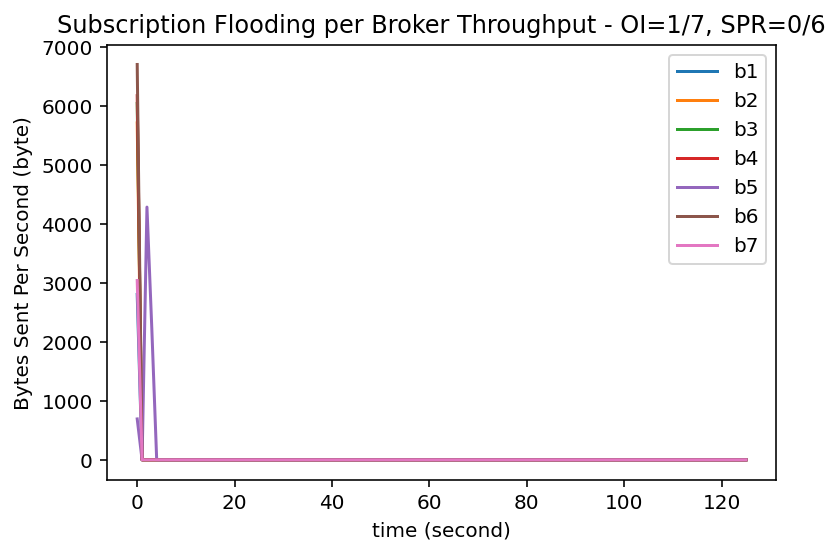

In [10]:
plot_all_rate(all_plot_data, plot_title="Subscription Flooding per Broker Throughput - OI=1/7, SPR=0/6")

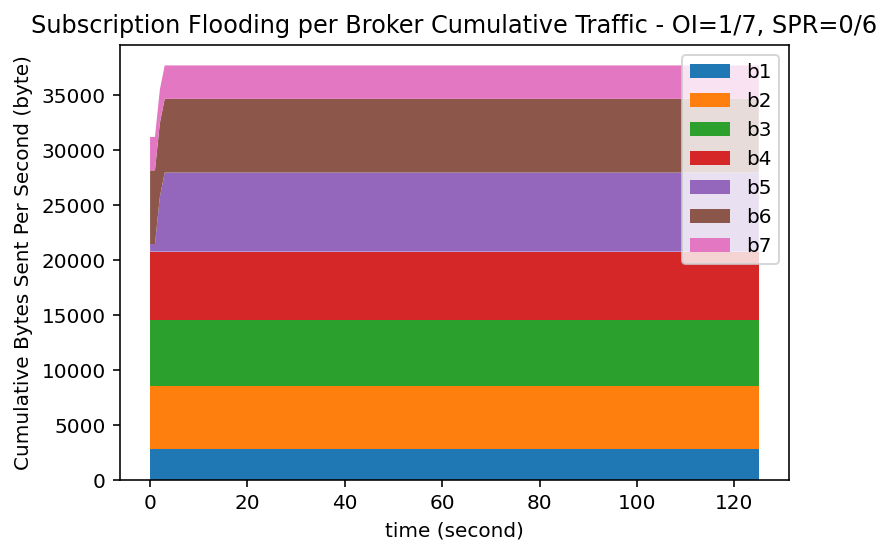

In [11]:
plot_all_cumu(all_plot_data, plot_title="Subscription Flooding per Broker Cumulative Traffic - OI=1/7, SPR=0/6")

# Heat Map Computation

> Note:
> - this section needs the previous section to be ran once

In [12]:
# contains a list of processed [ (rate_x, rate_y, cumu_x, cumu_y) ]
all_plot_data[6][-1][-1] #gets the cumulative count of broker 7's cumulative data's last entry

3038

In [13]:
# computes the sum of last cumulative datas
def compute_cumu_total(all_plot_data):
    total = 0
    count = 1
    for broker in all_plot_data:
        print("[ LOG ] Summing broker{}".format(count))
        count+=1
        broker_cumu_total = broker[-1][-1]
        total += broker_cumu_total
    return total

In [14]:
compute_cumu_total(all_plot_data)

[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7


37647

In [15]:
# computes the ratio of total_sf/total_pf
# e.g. @csv_dir_pf = "../THR_7-7/OI_7-7/linear_pf/csv/"
def compute_single_sub_pub_diff(csv_dir_sf, csv_dir_pf):
    global csv_dir
    # first computes sum of lasts for sf
    csv_dir = csv_dir_sf
    csv_files= my_init(csv_dir)
    all_data = parse_num_csv(csv_files)
    all_plot_data = process_all(all_data, num_brokers)
    sf_total = compute_cumu_total(all_plot_data)
    print("[ LOG ] Computed sf total {}".format(sf_total))
    # then computes sum of lasts for pf
    csv_dir = csv_dir_pf
    csv_files= my_init(csv_dir)
    all_data = parse_num_csv(csv_files)
    all_plot_data = process_all(all_data, num_brokers)
    pf_total = compute_cumu_total(all_plot_data)
    print("[ LOG ] Computed pf total {}".format(pf_total))
    return float(sf_total)/pf_total

In [16]:
# demo
compute_single_sub_pub_diff("../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/", 
                            "../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_pf/csv/")
# this one has almost no differece
compute_single_sub_pub_diff("../broker_container/data1/heat_map/THR_3-7/OI_1-7/linear_pf/csv/", 
                            "../broker_container/data1/heat_map/THR_3-7/OI_3-7/linear_pf/csv/") 

[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b1.csv] Total no. of rows: 6148
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b2.csv] Total no. of rows: 3686
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b3.csv] Total no. of rows: 3669
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b4.csv] Total no. of rows: 3641
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b5.csv] Total no. of rows: 3663
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b6.csv] Total no. of rows: 3686
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b7.csv] Total no. of rows: 3738
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 786381
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_pf/csv/b1.csv] Total no. of rows: 7560
[../broker_container/da

0.9592204052247248

In [17]:
# for example, iterating over ../THR_7-7/OI_7-7/linear_sf/csv/ means @base_dir = "../"
def compute_all_csv_dir(base_dir):
    global all_csv_dir
    all_csv_dir = []
    # since I have 4*4 for heat map, I do iterate over 7,5,3,1
    # note I do it in reverse order because the heat_map [0][0] start with 7/7 data
    for i in range(7, 0, -2):
        sub_sf_dir = "OI_{}-7/linear_sf/csv/".format(i)
        sub_pf_dir = "OI_{}-7/linear_pf/csv/".format(i)
        fake_array = []
        all_csv_dir.append(fake_array)
        for j in range(7, 0, -2):
            # notice we are going horizontal first
            sf_dir = "{}THR_{}-7/{}".format(base_dir, j, sub_sf_dir)
            pf_dir = "{}THR_{}-7/{}".format(base_dir, j, sub_pf_dir)
            fake_array.append((sf_dir, pf_dir))
    return all_csv_dir

# for some experiments, since data are the same, they are skipped
# for example, all pf for THR_3-7 will the same
def lazy_exp(base_dir):
    global all_csv_dir
    # since I have 4*4 for heat map, I do iterate over 7,5,3,1
    # note I do it in reverse order because the heat_map [0][0] start with 7/7 data
    for i in range(2, 4, 1):
        parent_dir = "{}THR_{}-7/".format(base_dir, int(7-i*2))
        for j in range(0, 4, 1):
            csv_pf_dir = "{}OI_3-7/linear_pf/csv/".format(parent_dir)
            original_sf = all_csv_dir[j][i][0]
            all_csv_dir[j][i] = (original_sf, csv_pf_dir)
    return all_csv_dir

In [18]:
all_csv_dir = []
# computes all the csv_directories into a matrix
compute_all_csv_dir("../broker_container/data1/heat_map/")
lazy_exp("../broker_container/data1/heat_map/")

[[('../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/',
   '../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_pf/csv/'),
  ('../broker_container/data1/heat_map/THR_5-7/OI_7-7/linear_sf/csv/',
   '../broker_container/data1/heat_map/THR_5-7/OI_7-7/linear_pf/csv/'),
  ('../broker_container/data1/heat_map/THR_3-7/OI_7-7/linear_sf/csv/',
   '../broker_container/data1/heat_map/THR_3-7/OI_3-7/linear_pf/csv/'),
  ('../broker_container/data1/heat_map/THR_1-7/OI_7-7/linear_sf/csv/',
   '../broker_container/data1/heat_map/THR_1-7/OI_3-7/linear_pf/csv/')],
 [('../broker_container/data1/heat_map/THR_7-7/OI_5-7/linear_sf/csv/',
   '../broker_container/data1/heat_map/THR_7-7/OI_5-7/linear_pf/csv/'),
  ('../broker_container/data1/heat_map/THR_5-7/OI_5-7/linear_sf/csv/',
   '../broker_container/data1/heat_map/THR_5-7/OI_5-7/linear_pf/csv/'),
  ('../broker_container/data1/heat_map/THR_3-7/OI_5-7/linear_sf/csv/',
   '../broker_container/data1/heat_map/THR_3-7/OI_3-7/linear_pf/csv/')

In [19]:
def compute_heat_map(all_csv_dir):
    hori = len(all_csv_dir[0])
    vert = len(all_csv_dir)
    heat_map = np.zeros((vert, hori))
    for i in range(vert):
        for j in range(hori):
            sf_dir, pf_dir = all_csv_dir[i][j]
            heat_map[i][j] = compute_single_sub_pub_diff(sf_dir, pf_dir)
    return heat_map    

In [20]:
heat_map = compute_heat_map(all_csv_dir)

[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b1.csv] Total no. of rows: 6148
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b2.csv] Total no. of rows: 3686
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b3.csv] Total no. of rows: 3669
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b4.csv] Total no. of rows: 3641
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b5.csv] Total no. of rows: 3663
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b6.csv] Total no. of rows: 3686
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_sf/csv/b7.csv] Total no. of rows: 3738
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 786381
[../broker_container/data1/heat_map/THR_7-7/OI_7-7/linear_pf/csv/b1.csv] Total no. of rows: 7560
[../broker_container/da

[../broker_container/data1/heat_map/THR_5-7/OI_5-7/linear_pf/csv/b7.csv] Total no. of rows: 2583
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed pf total 545154
[../broker_container/data1/heat_map/THR_3-7/OI_5-7/linear_sf/csv/b1.csv] Total no. of rows: 2658
[../broker_container/data1/heat_map/THR_3-7/OI_5-7/linear_sf/csv/b2.csv] Total no. of rows: 1657
[../broker_container/data1/heat_map/THR_3-7/OI_5-7/linear_sf/csv/b3.csv] Total no. of rows: 1659
[../broker_container/data1/heat_map/THR_3-7/OI_5-7/linear_sf/csv/b4.csv] Total no. of rows: 1676
[../broker_container/data1/heat_map/THR_3-7/OI_5-7/linear_sf/csv/b5.csv] Total no. of rows: 1730
[../broker_container/data1/heat_map/THR_3-7/OI_5-7/linear_sf/csv/b6.csv] Total no. of rows: 65
[../broker_container/data1/heat_map/THR_3-7/OI_5-7/linear_sf/csv/b7.csv] Total no. of rows: 33
[ LOG ] Summing broker1
[ L

[../broker_container/data1/heat_map/THR_5-7/OI_1-7/linear_sf/csv/b1.csv] Total no. of rows: 3956
[../broker_container/data1/heat_map/THR_5-7/OI_1-7/linear_sf/csv/b2.csv] Total no. of rows: 57
[../broker_container/data1/heat_map/THR_5-7/OI_1-7/linear_sf/csv/b3.csv] Total no. of rows: 48
[../broker_container/data1/heat_map/THR_5-7/OI_1-7/linear_sf/csv/b4.csv] Total no. of rows: 39
[../broker_container/data1/heat_map/THR_5-7/OI_1-7/linear_sf/csv/b5.csv] Total no. of rows: 48
[../broker_container/data1/heat_map/THR_5-7/OI_1-7/linear_sf/csv/b6.csv] Total no. of rows: 44
[../broker_container/data1/heat_map/THR_5-7/OI_1-7/linear_sf/csv/b7.csv] Total no. of rows: 16
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 9718
[../broker_container/data1/heat_map/THR_5-7/OI_1-7/linear_pf/csv/b1.csv] Total no. of rows: 5711
[../broker_container/data1/heat_map/T

In [21]:
# compute_single_sub_pub_diff("../THR_3-7/OI_5-7/linear_sf/csv/", "../THR_3-7/OI_5-7/linear_pf/csv/")

In [22]:
def heat_map_plot(data_matrix, x_axis, y_axis, plot_title="", char_label="SF Total / PF Total"):
    plt.clf()
    fig, ax = plt.subplots()
    im = ax.imshow(data_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(char_label, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_yticks(np.arange(len(y_axis)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(x_axis)
    ax.set_yticklabels(y_axis)
    
    plt.title("{}".format(plot_title))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(len(x_axis)):
        for j in range(len(y_axis)):
            text = ax.text(j, i, "{:.2f}".format(data_matrix[i, j]),
                           ha="center", va="center", color="black")
    return fig

<Figure size 432x288 with 0 Axes>

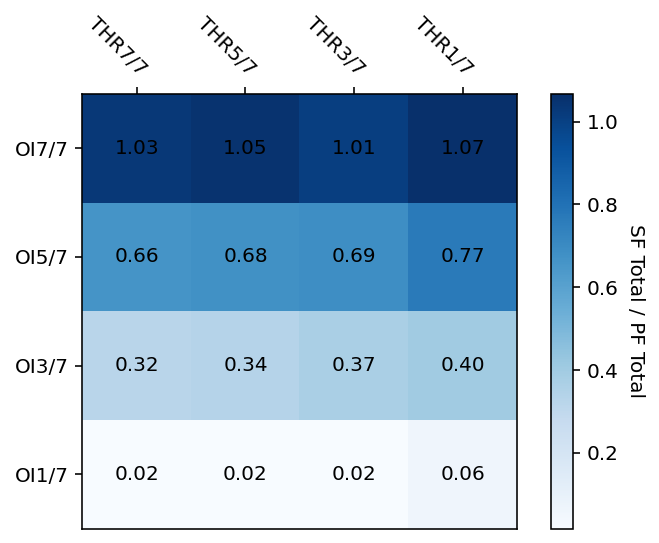

In [23]:
heat_x_axis = ["OI7/7", "OI5/7", "OI3/7", "OI1/7"]
heat_y_axis =  ["THR7/7", "THR5/7", "THR3/7", "THR1/7"]

fig = heat_map_plot(heat_map, heat_y_axis, heat_x_axis)
# saves figure but not axis
# fig.savefig('./heat_map.png', dpi=300)

## Heat Map Model
this uses the model I developed and written down in the tex/markdown file

[0][0] -> OI=1.0 THR=0.01
[0][1] -> OI=1.0 THR=0.013999999999999999
[0][2] -> OI=1.0 THR=0.023333333333333334
[0][3] -> OI=1.0 THR=0.07
[1][0] -> OI=0.6666666666666666 THR=0.01
[1][1] -> OI=0.6666666666666666 THR=0.013999999999999999
[1][2] -> OI=0.6666666666666666 THR=0.023333333333333334
[1][3] -> OI=0.6666666666666666 THR=0.07
[2][0] -> OI=0.3333333333333333 THR=0.01
[2][1] -> OI=0.3333333333333333 THR=0.013999999999999999
[2][2] -> OI=0.3333333333333333 THR=0.023333333333333334
[2][3] -> OI=0.3333333333333333 THR=0.07
[3][0] -> OI=0.0 THR=0.01
[3][1] -> OI=0.0 THR=0.013999999999999999
[3][2] -> OI=0.0 THR=0.023333333333333334
[3][3] -> OI=0.0 THR=0.07


<Figure size 432x288 with 0 Axes>

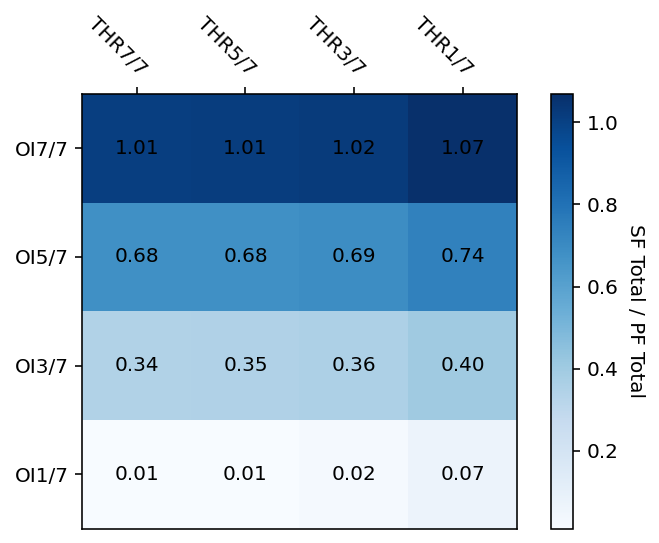

In [24]:
hm_ratio = []
hm_prediction = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        THR = float(7-2*j)/float(7)
        OI_term = float(6-2*i)/float(7-1)
        THR_term = (1.0/100.0) * (1.0/(THR))
        print("[{}][{}] -> OI={} THR={}".format(i,j,OI_term, THR_term))
        hm_prediction[i][j] = OI_term + THR_term
fig = heat_map_plot(hm_prediction, heat_y_axis, heat_x_axis)
# saves figure
# fig.savefig('./heat_map_prediction.png', dpi=300)

# Grand Heat Map

In [25]:
compute_single_sub_pub_diff("../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/", 
                            "../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/")
# this one has almost no differece

[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b1.csv] Total no. of rows: 755
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b2.csv] Total no. of rows: 367
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b3.csv] Total no. of rows: 366
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b4.csv] Total no. of rows: 366
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b5.csv] Total no. of rows: 367
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b6.csv] Total no. of rows: 367
[../broker_container/data1/grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b7.csv] Total no. of rows: 184
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 77394
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b1.csv] Total n

0.9992253466573708

In [26]:
# for example, iterating over ../THR_7-7/OI_7-7/linear_sf/csv/ means @base_dir = "../"
def grand_compute_all_csv_dir(base_dir, first_level_name, second_level_name):
    global grand_all_csv_dir
    grand_all_csv_dir = []
    # since I have 4*4 for heat map, I do iterate over 7,5,3,1
    # note I do it in reverse order because the heat_map [0][0] start with 7/7 data
    for i in range(1, 8, 2):
        sub_sf_dir = "{}_{}-7/linear_sf/csv/".format(second_level_name, i)
        sub_pf_dir = "{}_{}-7/linear_pf/csv/".format(second_level_name, i)
        fake_array = []
        grand_all_csv_dir.append(fake_array)
        for j in range(6, -1, -2):
            # notice we are going horizontal first
            # e.g. {}SPR_{}-7/{OI_7-7/linear_sf/csv/}
            sf_dir = "{}{}_{}-6/{}".format(base_dir, first_level_name, j, sub_sf_dir)
            pf_dir = "{}{}_{}-6/{}".format(base_dir, first_level_name, j, sub_pf_dir)
            fake_array.append((sf_dir, pf_dir))
    return grand_all_csv_dir

# for some experiments, since data are the same, they are skipped
# for example, ALL pf are the same in this experiement, since I configured all to have 100 pub
def grand_lazy_exp(base_dir, first_level_name, second_level_name):
    global grand_all_csv_dir
    for i in range(0, 4, 1):
        for j in range(0, 4, 1):
            # notice we are going horizontal first
            # e.g. {}SPR_{}-7/{OI_7-7/linear_sf/csv/}
            original_sf = grand_all_csv_dir[i][j][0]
            fake_pf = pf_dir = "{}{}_6-6/{}_1-7/linear_pf/csv/".format(base_dir, first_level_name, second_level_name)
            grand_all_csv_dir[i][j] = (original_sf, fake_pf)
    return grand_all_csv_dir

In [27]:
grand_all_csv_dir = []
# computes all the csv_directories into a matrix
grand_all_csv_dir = grand_compute_all_csv_dir("../broker_container/data1/grand_heat_map/", "SPR", "OI")
grand_all_csv_dir = grand_lazy_exp("../broker_container/data1/grand_heat_map/","SPR", "OI")
# grand_all_csv_dir

In [28]:
grand_heat_map = compute_heat_map(grand_all_csv_dir)

[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b1.csv] Total no. of rows: 651
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b2.csv] Total no. of rows: 204
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b3.csv] Total no. of rows: 255
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b4.csv] Total no. of rows: 209
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b5.csv] Total no. of rows: 211
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b6.csv] Total no. of rows: 247
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b7.csv] Total no. of rows: 119
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 48774
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b1.csv] Total n

[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 58941
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b1.csv] Total no. of rows: 753
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b2.csv] Total no. of rows: 367
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b3.csv] Total no. of rows: 367
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b4.csv] Total no. of rows: 367
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b5.csv] Total no. of rows: 367
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b6.csv] Total no. of rows: 367
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b7.csv] Total no. of rows: 184
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Comput

[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b6.csv] Total no. of rows: 367
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b7.csv] Total no. of rows: 184
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed pf total 77454
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_7-7/linear_sf/csv/b1.csv] Total no. of rows: 677
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_7-7/linear_sf/csv/b2.csv] Total no. of rows: 592
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_7-7/linear_sf/csv/b3.csv] Total no. of rows: 543
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_7-7/linear_sf/csv/b4.csv] Total no. of rows: 528
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_7-7/linear_sf/csv/b5.csv] Total no. of rows: 557
[../broker_container/data1/grand_heat_map/SPR_6-6/OI_7-7/linear_sf/csv/b6.csv] Total n

<Figure size 432x288 with 0 Axes>

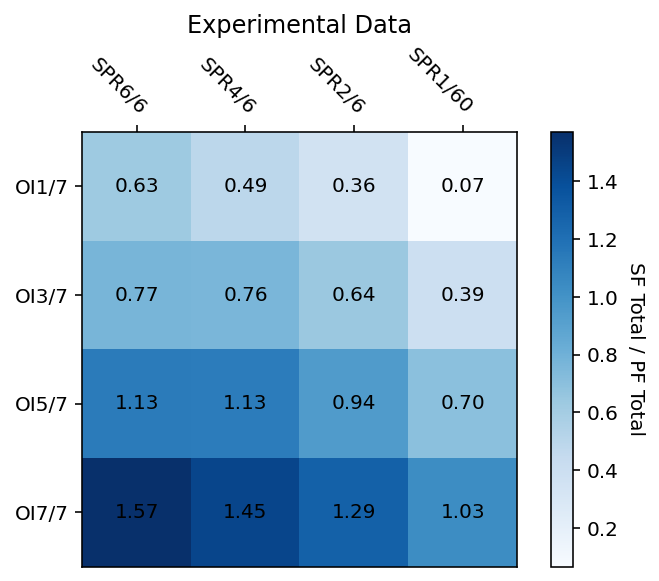

In [29]:
grand_heat_y_axis = ["OI1/7", "OI3/7", "OI5/7", "OI7/7"]
grand_heat_x_axis =  ["SPR6/6", "SPR4/6", "SPR2/6", "SPR1/60"]

fig = heat_map_plot(grand_heat_map, grand_heat_x_axis, grand_heat_y_axis, "Experimental Data")
# fig.savefig('./grand_heat_map.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

It turns out that assuming $\frac{1}{2}$ probability of **subscribe + subback + tcp_ack collapsing** would be somewhat better than the raw prediction of
$$
\begin{align*}
\frac{\text{total sb} }{\text{total pb} }
    &= \frac{OI \cdot B_n - 1}{B_n - 1} +
    \frac{m_s \cdot s_t}{m_p \cdot p_t}  \to \frac{OI \cdot B_n - 1}{B_n - 1} +
    \frac{m_s \cdot s_t \cdot \frac{1}{2}}{m_p \cdot p_t}
.\end{align*}
$$

# Grand Heat Map Prediction


### Without 0.5 ratio fix

<Figure size 432x288 with 0 Axes>

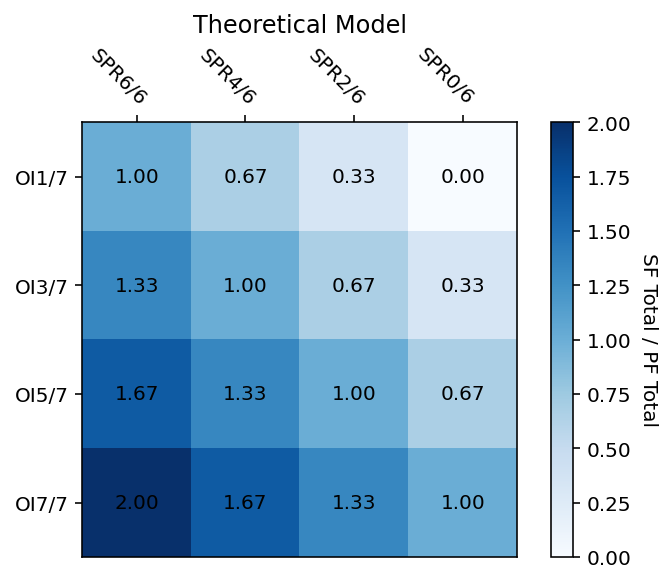

In [30]:
predict_grand_heat_x_axis =  ["SPR6/6", "SPR4/6", "SPR2/6", "SPR0/6"]
grand_hm_prediction = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        OI_term = (2.0*i)/float(7-1)
        SPR_term = (6-2*j)/6.0
        grand_hm_prediction[i][j] = OI_term + SPR_term
fig = heat_map_plot(grand_hm_prediction, predict_grand_heat_x_axis, grand_heat_y_axis, "Theoretical Model")
# saves figure
# fig.savefig('./grand_heat_map_prediction.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

### With 0.5 ratio fix

<Figure size 432x288 with 0 Axes>

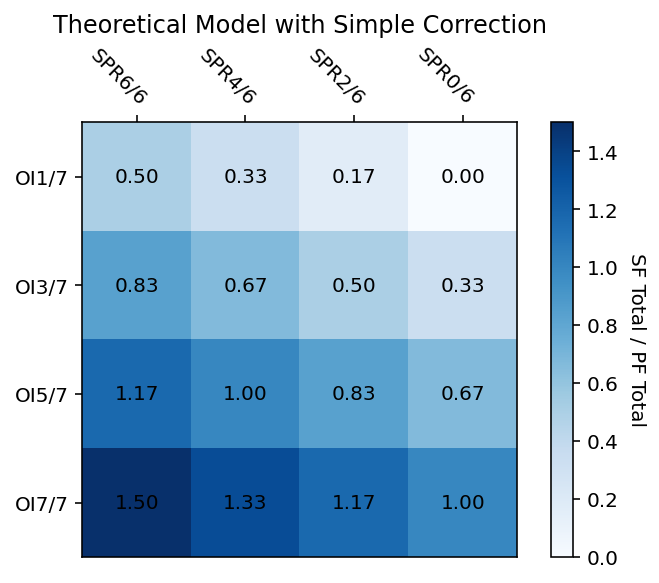

In [31]:
grand_hm_prediction_2 = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        OI_term = float(2*i)/float(7-1)
        SPR_term = (6-2*j)/6.0
        grand_hm_prediction_2[i][j] = OI_term + SPR_term * (0.5)
fig = heat_map_plot(grand_hm_prediction_2, predict_grand_heat_x_axis, grand_heat_y_axis, "Theoretical Model with Simple Correction")
# saves figure
# fig.savefig('./grand_heat_map_prediction_with_correction.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

### Without 0.5 fix and 1/60 instead of 0/6

<Figure size 432x288 with 0 Axes>

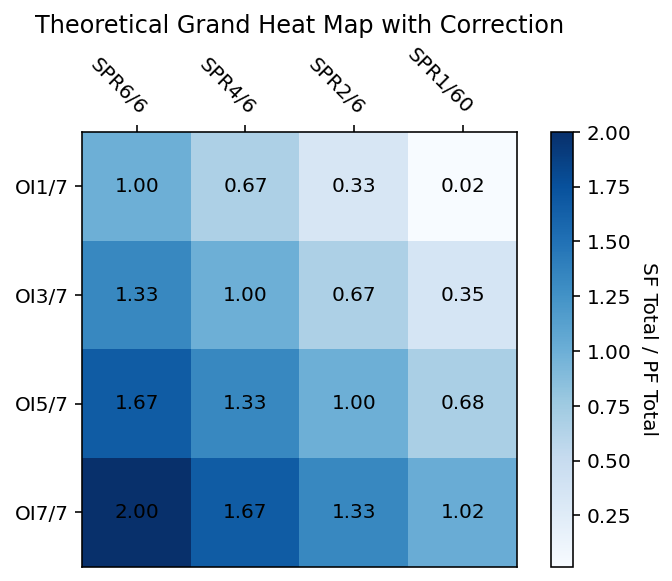

In [32]:
grand_hm_prediction_3 = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        if j == 3:
            SPR_term = (1)/60.0
        else:
            SPR_term = (6-2*j)/6.0
        OI_term = float(2*i)/float(7-1)
        grand_hm_prediction_3[i][j] = OI_term + SPR_term
fig = heat_map_plot(grand_hm_prediction_3, grand_heat_x_axis, grand_heat_y_axis, "Theoretical Grand Heat Map with Correction")
# saves figure
# fig.savefig('./grand_heat_map_prediction_exact_with_correction.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

### Ratio Computation
- larger number means **larger collapse rate**

<Figure size 432x288 with 0 Axes>

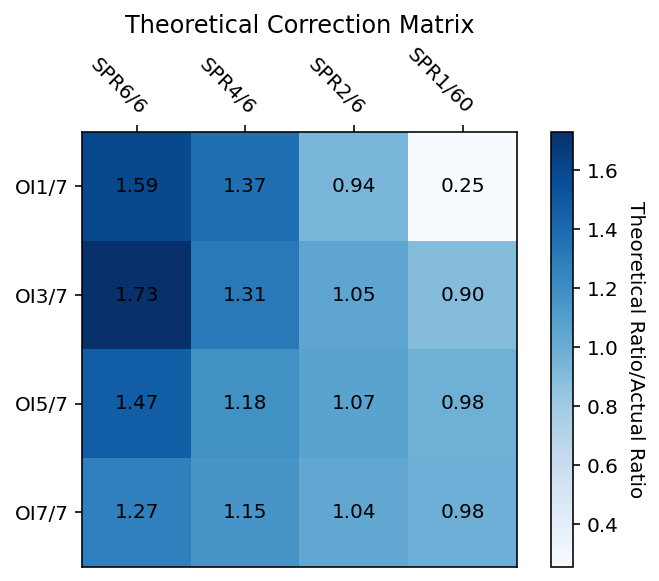

In [33]:
grand_hm_ratio = np.divide(grand_hm_prediction_3, grand_heat_map)

fig = heat_map_plot(grand_hm_ratio, grand_heat_x_axis, grand_heat_y_axis, 
                    "Theoretical Correction Matrix", "Theoretical Ratio/Actual Ratio")
# saves figure
# fig.savefig('./grand_heat_map_correction_matrix.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

so we see that:
- the more broker it needs to send, the **more** the **publish** (including `TCP_ACK`) collapsing (minor)
- the more subscriber there are, the **more** the **subscribe** (including `TCP_ACK`) collapsing
    - in fact, another factor is: the less broker it sends, the **more** the **subscribe** (including `TCP_ACK`) collapsing

# Delay Graphs

In [34]:
# some related MQTT + tshark constants
mqtt_msgtype = { 1: "connect", 2: "connack", 
                3: "publish", 4: "pubback", 5: "pubrec", 6: "pubrel", 7: "pubcomp",
                8: "subscribe", 9: "subback"}

In [35]:
delay_csv_dir = "../broker_container/data1/delay_graph/tc-0/linear_pf/csv/"
delay_files = my_init(delay_csv_dir)

In [36]:
def str_to_int_converter(field_data):
    if(field_data is None):
        return field_data
    parsed = field_data.split('^')
    result = []
    for data in parsed:
        result.append(int(data))
    return result

def mqtt_msgtype_converter(field_data):
    global mqtt_msgtype
    if(field_data is None):
        return field_data
    parsed = field_data.split('^')
    result = []
    for data in parsed:
        result.append((int(data), mqtt_msgtype.get(int(data))))
    return result
    
# applies some preprocessing to @field_data, and feed it to @converter function
def csv_field_converter(field_data, converter):
    if(field_data is None):
        return converter(field_data)
    elif(isinstance(field_data, str)):
        field_data.strip()
        if(field_data):
            return converter(field_data)
        else:
            return converter(None)
    else:
        return converter(field_data)
        
    
def parse_single_delay_csv(filename):
    fields = []
    rows = []

    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)

        # extracting field names through first row
        fields = next(csvreader)

        for row in csvreader:
            rows.append({ 
                'time': float(row[0]), 
                'len': int(row[1]), 
                'src': row[2], 
                'dst': row[3],
                'msgtype':csv_field_converter(row[4], mqtt_msgtype_converter),
                'msgid':csv_field_converter(row[-1], str_to_int_converter)
            })
        needed_fields = [0,1,2,3,4,-1]
        fields = [fields[index] for index in needed_fields]

        print("[{}] Total no. of rows: {}".format(filename, csvreader.line_num))
    return (fields, rows)

# returns a list of [ (field, data), (field, data) ]  for each csv in @csv_files
def parse_num_delay_csv(csv_files):
    result = []
    for file in csv_files:
        # print("parsing "+file)
        result.append(parse_single_delay_csv(file))
    return result

In [37]:
"""
computes the correct time offset between src and dst, by looking at the time for CONNECT command
because tcpdump aligns time, so it appears that
    sub_connect at t=0 (approx)
    pub_connect at t=0 as well (approx)!
but in fact, I have configured pub_connect to be 5 seconds later
"""
def compute_src_dst_offset(src_raw, src_broker_num, dst_raw, dst_broker_num, exp_offset=5):
    src_data = my_delay_filter(src_raw, clients, clients, 1)
    if(src_data is None or len(src_data) == 0):
        print("[ ERROR ] no connect found for src_raw")
        return None
    dst_data = my_delay_filter(dst_raw, clients, clients, 1)
    if(dst_data is None or len(dst_data) == 0):
        print("[ ERROR ] no connect found for dst_raw")
        return None
    print("[ LOG ] offset between dst={} and src={}".format(dst_data[0]['time'], src_data[0]['time']))
    return exp_offset + dst_data[0]['time'] - src_data[0]['time']
    #return exp_offset + abs(dst_data[0]['time'] - src_data[0]['time'])

In [38]:
# list version of check_in_multiple() function, where input @src could be list
def list_check_in_multiple(src, filters):
    if(filters is None or len(filters) == 0):
        print("[ DEBUG ] not filters passed in")
        return False
    
    if(src is None or len(src)==0):
        return False #don't want to match this time
    
    for data in src:
        if(check_in_multiple(data[0], filters)):
            # print("[ DEBUG ] {} matches {}".format(data[0], filter))
            return True
    return False

# filters data by excluding rows that matches @src_ip and @dst_ip
# assumes @msg_type is int
def my_delay_filter(data, src_ip_filter, dst_ip_filter, msg_type):
    filtered = []
    if(not isinstance(msg_type, list)):
        msg_type = [msg_type]
    
    if data is None or len(data) == 0:
        print("[ ERROR my_delay_filter ] no data given")
        return
    for row in data:
        condition_1 = check_in_multiple(row['src'], src_ip_filter)
        condition_2 = not check_in_multiple(row['dst'], dst_ip_filter)        
        condition_3 = list_check_in_multiple(row['msgtype'], msg_type)
        if(condition_1 and condition_2 and condition_3):
            filtered.append(row)
    return filtered

# process_single(f_tmp, r_tmp, 1)
# @is_src = 1 means we are interested in broker->broker data. Otherwise, broker->client data
def delay_process_single(fields, rows, broker_num, is_src = 1):
    src_filter = [brokers[broker_num]]
    # src_filter = clients if is_src else [brokers[broker_num]]
    dst_filter = clients if is_src else brokers[1:]
    # process data
    result = my_delay_filter(rows, src_filter, dst_filter, 3)
    return result

'''
@all_data: consists of raw data in the form of [ (field, rows) ] 
@selected: specifies which data in @all_data to process, in the form of [ index_1, index_2, ... ] 
@dst_pos: an index which specifies the position of data that is broker->client
    takes in @all_data and processes the selected one specified at @selected
    returns a list of [ (processed_data) ]  for each data of type (field, data) in @all_data
'''
def delay_process_all(all_data, selected, dst_pos):
    result = []
    for i in selected:
        fld, data = all_data[i]
        is_src = 1 if i!=dst_pos else 0
        result.append(delay_process_single(fld, data, i+1, is_src))
    return result

In [39]:
delay_all_raw_data = parse_num_delay_csv(delay_files)
delay_all_data = delay_process_all(delay_all_raw_data, [0,6], 6)
delay_time_offset = compute_src_dst_offset(delay_all_raw_data[0][1], 1, delay_all_raw_data[6][1], 7)

[../broker_container/data1/delay_graph/tc-0/linear_pf/csv/b1.csv] Total no. of rows: 97635
[../broker_container/data1/delay_graph/tc-0/linear_pf/csv/b2.csv] Total no. of rows: 71672
[../broker_container/data1/delay_graph/tc-0/linear_pf/csv/b3.csv] Total no. of rows: 71015
[../broker_container/data1/delay_graph/tc-0/linear_pf/csv/b4.csv] Total no. of rows: 71247
[../broker_container/data1/delay_graph/tc-0/linear_pf/csv/b5.csv] Total no. of rows: 71141
[../broker_container/data1/delay_graph/tc-0/linear_pf/csv/b6.csv] Total no. of rows: 71319
[../broker_container/data1/delay_graph/tc-0/linear_pf/csv/b7.csv] Total no. of rows: 56114
[ LOG ] offset between dst=1.835159 and src=0.000618


In [40]:
def reset_find_msg_id_in_dst():
    find_msg_id_in_dst.curr_pos = 0
    find_msg_id_in_dst.packet_loss = set()
    find_msg_id_in_dst.packet_malformed = set()
    return 

# @delay_data is a list of [ {data1}, {data2}, ... ]
def find_msg_id_in_dst(target_id, delay_data):
    # mimics a function static variable
    if not hasattr(find_msg_id_in_dst, "curr_pos"):
        find_msg_id_in_dst.curr_pos = 0  # it doesn't exist yet, so initialize it
        find_msg_id_in_dst.packet_loss = set()
        find_msg_id_in_dst.packet_malformed = set()
    """
    for pos, data in enumerate(delay_data):
        if(data['msgid'] is None):
            find_msg_id_in_dst.packet_malformed.add(data['time'])
            continue # malformed packet
        if(target_id in data['msgid']):
            find_msg_id_in_dst.curr_pos = pos
            return data
    find_msg_id_in_dst.packet_loss.add(target_id)
    return None
    
    """
    # for optimization
    prev_pos = find_msg_id_in_dst.curr_pos
    if(prev_pos >= len(delay_data)):
        curr_dst = delay_data[-2]
    else:
        curr_dst = delay_data[prev_pos]
    
    if curr_dst is None:
        print("[ ERROR ] curr_dst is none ")
        return None
    
    dst_ids = curr_dst['msgid']
    if(target_id in dst_ids):
        #found
        return curr_dst
    elif(target_id not in dst_ids and (len(delay_data) > prev_pos+2)):
        # if not found, look one beyond
        future_dst = delay_data[prev_pos+1]
        if(future_dst['msgid'] is None or target_id not in future_dst['msgid']):
            # print("[ DEBUG ] not found {} at {}".format(target_id, future_dst['time']))
            for pos, data in enumerate(delay_data):
                if(data['msgid'] is None):
                    find_msg_id_in_dst.packet_malformed.add(data['time'])
                    continue # malformed packet
                if(target_id in data['msgid']):
                    find_msg_id_in_dst.curr_pos = pos
                    return data
            find_msg_id_in_dst.packet_loss.add(target_id)
            return None
        else:
            # is in the next data
            find_msg_id_in_dst.curr_pos += 1
            return future_dst
    find_msg_id_in_dst.packet_loss.add(target_id)
    return None # not found


def delay_compute_mgs_delay(delay_src, delay_dst, offset_time = 5):
    x_msg_ids = []
    y_msg_delay = []
    
    prev_msg_id = 0
    for src_data in delay_src:
        src_ids = src_data['msgid']
        if(src_ids is None):
            # malformed packets
            continue
        # compute the diff of src_ids
        for pos, src_id in enumerate(src_ids):
            # sometimes, pubrel could be in the same packet
            if(src_data['msgtype'][pos][0] != 3):
                continue
            curr_dst = find_msg_id_in_dst(src_id, delay_dst)
            # found
            if(curr_dst is not None):
                x_msg_ids.append(src_id)
                # package loss since src broker
                if(src_id - prev_msg_id > 1):
                    find_msg_id_in_dst.packet_loss.update(list(range(prev_msg_id+1, src_id)))
                prev_msg_id = src_id
                y_msg_delay.append(curr_dst['time'] - (offset_time + src_data['time']))
                # y_msg_delay.append(curr_dst['time'] - src_data['time'] + offset_time)
                if(src_id in find_msg_id_in_dst.packet_loss):
                    find_msg_id_in_dst.packet_loss.remove(src_id)
            else:
                # skip if not found
                # print("[ INFO ] not found {} with p_loss={}".format(src_id, len(find_msg_id_in_dst.packet_loss)))
                pass
    return (x_msg_ids,  y_msg_delay)   

In [41]:
reset_find_msg_id_in_dst()
delay_x, delay_y = delay_compute_mgs_delay(delay_all_data[0], delay_all_data[1])
delay_time_offset, find_msg_id_in_dst.packet_loss

(6.834541, {10000})

In [42]:
def delay_plot_single(delay_x, delay_y, plot_base_name="", scatter=False, ylim=-1):
    plt.clf()
    if ylim > 0:
        plt.ylim([0, ylim])
    if scatter:
        plt.plot(delay_x, delay_y, '.', color='royalblue')
    else:
        plt.plot(delay_x, delay_y)
    plt.xlabel('Publish Msg id')
    plt.ylabel('Delay per Publish Msg (sec)')
    plt.title("{} Broker End-to-end Delay per Publish Msg".format(plot_base_name))
    return

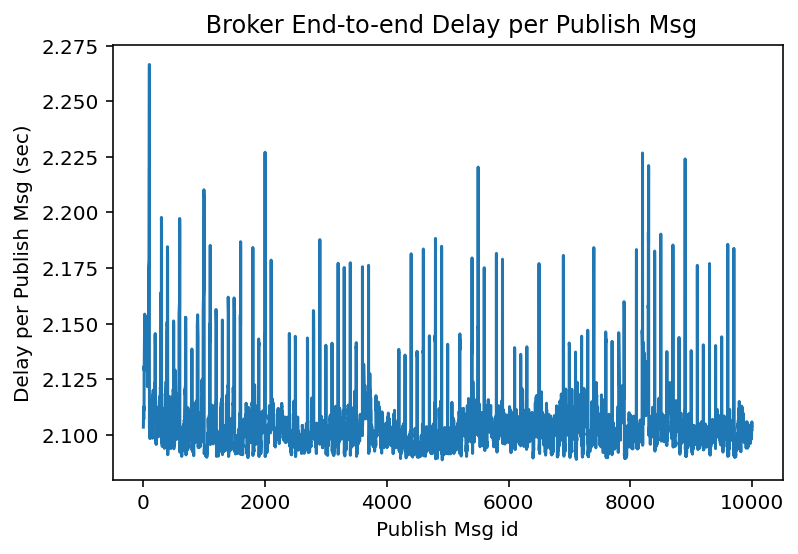

In [43]:
delay_plot_base_name = ""
delay_plot_single(delay_x, delay_y)

In [44]:
"""
@delay_csv_dir: e.g. "../broker_container/data1/delay_graph/tc-0/linear_pf/csv/"
@broker_pos: e.g. to compute the msg diff between broker 1 and 7, pass in [0,6]
"""
def display_delay_graph(csv_dir, broker_pos, plot_base_name="", forced_delay_time_offset = -1, scatter = False, ylim=-1):
    delay_csv_dir = csv_dir
    delay_files = my_init(delay_csv_dir)
    delay_all_raw_data = parse_num_delay_csv(delay_files)
    delay_all_data = delay_process_all(delay_all_raw_data, broker_pos, broker_pos[-1])
    start_pos = broker_pos[0]
    end_pos = broker_pos[-1]
    reset_find_msg_id_in_dst()
    try:
        delay = compute_src_dst_offset(delay_all_raw_data[start_pos][1], start_pos+1, 
                                               delay_all_raw_data[end_pos][1], end_pos+1)
    except:
        print("[ INFO ] defaultling time offset to 0")
        delay = 0
        # no op
    if(forced_delay_time_offset == -1):
        forced_delay_time_offset = delay
    print("configured forced_delay_time_offset = {}".format(forced_delay_time_offset))
    delay_x, delay_y = delay_compute_mgs_delay(delay_all_data[0], delay_all_data[1], forced_delay_time_offset)
    avg_delay = sum(delay_y)/float(len(delay_y))
    delay_plot_single(delay_x, delay_y, plot_base_name, scatter, ylim)
    print("[ INFO ] packet loss = {}, packet malformed = {}".format(len(find_msg_id_in_dst.packet_loss), 
                                                           len(find_msg_id_in_dst.packet_malformed)))
    print("[ INFO ] avg_delay = {}".format(avg_delay))
    return (find_msg_id_in_dst.packet_loss, find_msg_id_in_dst.packet_malformed, avg_delay)

[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b1.csv] Total no. of rows: 71059
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b2.csv] Total no. of rows: 7534
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b3.csv] Total no. of rows: 7275
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b4.csv] Total no. of rows: 6797
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b5.csv] Total no. of rows: 6243
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b6.csv] Total no. of rows: 6346
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b7.csv] Total no. of rows: 9173
[ LOG ] offset between dst=2.210776 and src=3.899372
configured forced_delay_time_offset = 3.311404
[ INFO ] packet loss = 3957, packet malformed = 3
[ INFO ] avg_delay = 6.461226659843636


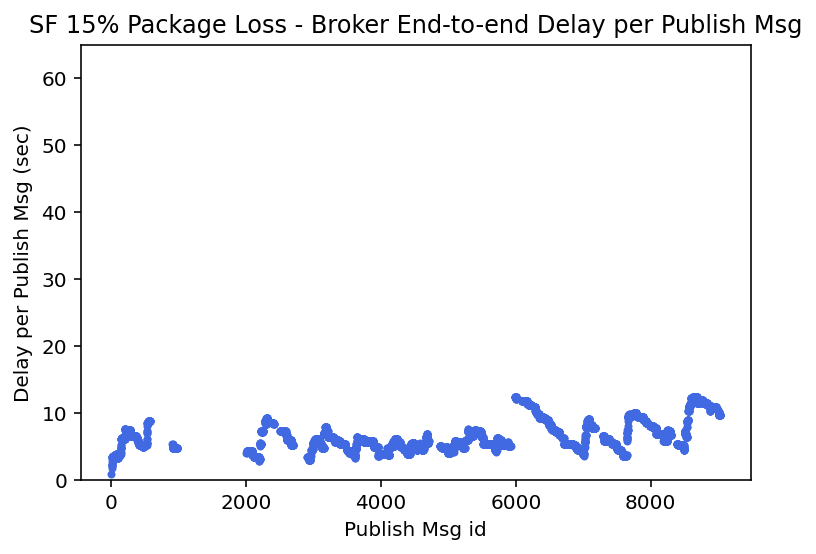

In [45]:
tc = 15
spf = "sf"
p_loss, p_mal, avg_delay = display_delay_graph(
    "../broker_container/data1/delay_graph/tc-{}/linear_{}/csv/".format(tc, spf),
    [0,6], "{} {}% Package Loss -".format(spf.upper(), tc), -1, True, 65)
# save_plot("delay/axis_correction/delay_plot_{}_tc-{}_scatter_v2".format(spf, tc))
# save_plot("delay/delay_plot_{}_tc-{}_scatter".format(spf, tc))
# p_loss

In [46]:
"""
@delay_csv_dir: e.g. "../../delay_graph/tc-0/linear_pf/csv/"
@broker_pos: e.g. to compute the msg diff between broker 1 and 7, pass in [0,6]
"""
def no_display_delay_graph(csv_dir, broker_pos, plot_base_name="", forced_delay_time_offset = -1):
    delay_csv_dir = csv_dir
    delay_files = my_init(delay_csv_dir)
    delay_all_raw_data = parse_num_delay_csv(delay_files)
    delay_all_data = delay_process_all(delay_all_raw_data, broker_pos, broker_pos[-1])
    start_pos = broker_pos[0]
    end_pos = broker_pos[-1]
    reset_find_msg_id_in_dst()
    try:
        delay = compute_src_dst_offset(delay_all_raw_data[start_pos][1], start_pos+1, 
                                               delay_all_raw_data[end_pos][1], end_pos+1)
    except:
        print("[ INFO ] defaultling time offset to 0")
        delay = 0
        # no op
    if(forced_delay_time_offset == -1):
        forced_delay_time_offset = delay
    print("configured forced_delay_time_offset = {}".format(forced_delay_time_offset))
    delay_x, delay_y = delay_compute_mgs_delay(delay_all_data[0], delay_all_data[1], forced_delay_time_offset)
    avg_delay = sum(delay_y)/float(len(delay_y))
    print("[ INFO ] packet loss = {}, packet malformed = {}".format(len(find_msg_id_in_dst.packet_loss), 
                                                           len(find_msg_id_in_dst.packet_malformed)))
    print("[ INFO ] avg_delay = {}".format(avg_delay))
    return (find_msg_id_in_dst.packet_loss, find_msg_id_in_dst.packet_malformed, avg_delay)

In [47]:
# trend plot
all_avg_delay = []
all_p_loss = []
tc_values = [0,5,10,15,20,25]
for i in tc_values:
    tc = i
    spf = "sf"
    p_loss, p_mal, avg_delay = no_display_delay_graph(
        "../broker_container/data1/delay_graph/tc-{}/linear_{}/csv/".format(tc, spf),
        [0,6], "{} {}% Package Loss -".format(spf.upper(), tc), -1)
    all_avg_delay.append(avg_delay)
    all_p_loss.append(len(p_loss))

[../broker_container/data1/delay_graph/tc-0/linear_sf/csv/b1.csv] Total no. of rows: 97543
[../broker_container/data1/delay_graph/tc-0/linear_sf/csv/b2.csv] Total no. of rows: 71906
[../broker_container/data1/delay_graph/tc-0/linear_sf/csv/b3.csv] Total no. of rows: 72006
[../broker_container/data1/delay_graph/tc-0/linear_sf/csv/b4.csv] Total no. of rows: 72662
[../broker_container/data1/delay_graph/tc-0/linear_sf/csv/b5.csv] Total no. of rows: 72827
[../broker_container/data1/delay_graph/tc-0/linear_sf/csv/b6.csv] Total no. of rows: 72647
[../broker_container/data1/delay_graph/tc-0/linear_sf/csv/b7.csv] Total no. of rows: 75527
[ LOG ] offset between dst=1.748398 and src=5.246843
configured forced_delay_time_offset = 1.5015549999999998
[ INFO ] packet loss = 1, packet malformed = 0
[ INFO ] avg_delay = 0.2719817889789007
[../broker_container/data1/delay_graph/tc-5/linear_sf/csv/b1.csv] Total no. of rows: 75755
[../broker_container/data1/delay_graph/tc-5/linear_sf/csv/b2.csv] Total no.

Text(0.5, 1.0, 'Average Broker End-to-end Delay vs Package Loss Rate')

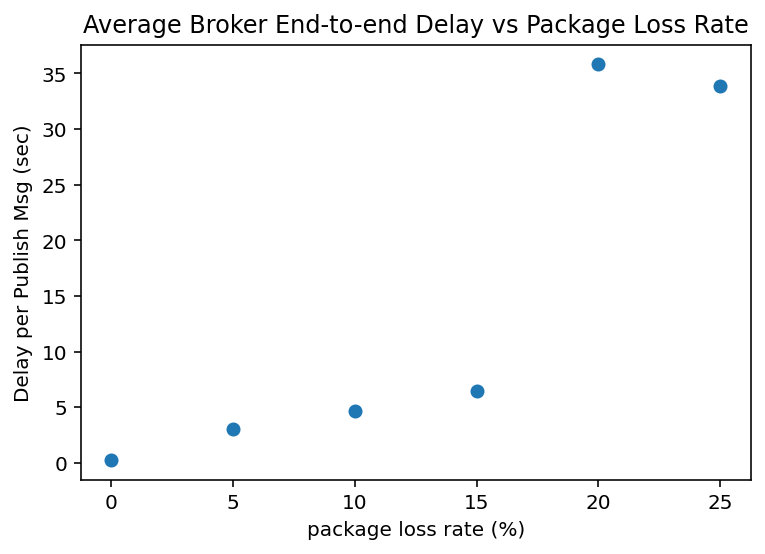

In [48]:
plt.clf()
plt.scatter(tc_values, all_avg_delay)
plt.xlabel('package loss rate (%)')
plt.ylabel('Delay per Publish Msg (sec)')
plt.title("Average Broker End-to-end Delay vs Package Loss Rate")
# save_plot("delay/avg_delay_sf")

Text(0.5, 1.0, 'Total SF Package Not Captured vs Package Loss Rate')

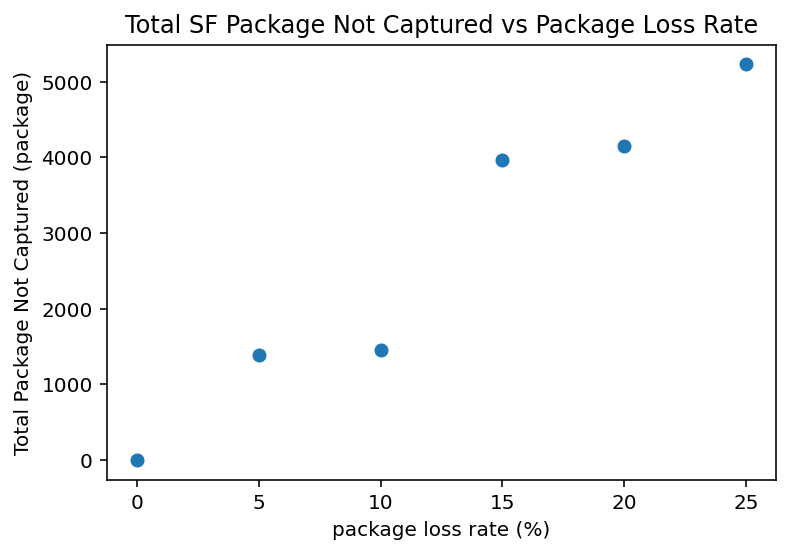

In [49]:
plt.clf()
plt.scatter(tc_values, all_p_loss)
plt.xlabel('package loss rate (%)')
plt.ylabel('Total Package Not Captured (package)')
plt.title("Total SF Package Not Captured vs Package Loss Rate")
#save_plot("delay/total_ploss_sf")

##### making sure "lost packages" are not captured

In [50]:
test_file = '../broker_container/data1/delay_graph/tc-5/linear_sf/csv/b7.csv'
f_tmp, r_tmp = parse_single_delay_csv(test_file)

[../broker_container/data1/delay_graph/tc-5/linear_sf/csv/b7.csv] Total no. of rows: 28851


In [51]:
def brute_force_find(p_loss_id, r_data):
    for r_row in r_data:
        ids = r_row['msgid']
        types = r_row['msgtype']
        if ids is None or types is None:
            continue
        for index, mid in enumerate(ids):
            mtype = types[index]
            # if(mid == p_loss_id and mtype in [3,4,5,6]):
            if(mid == p_loss_id):
                # found
                # print("[ INFO ] found {} at {}".format(p_loss_id, r_row))
                return r_row
    return None

def find_pub_related_in_data(p_loss_list, r_data):
    reset_find_msg_id_in_dst()
    for p_loss_id in p_loss_list:
        found = brute_force_find(p_loss_id, r_data)
        if found is None:
            print("[ INFO ] not found {}".format(p_loss_id))
        else:
            # found
            continue

In [52]:
find_pub_related_in_data(p_loss, r_tmp) # everything is FOUND!

### Delay Model

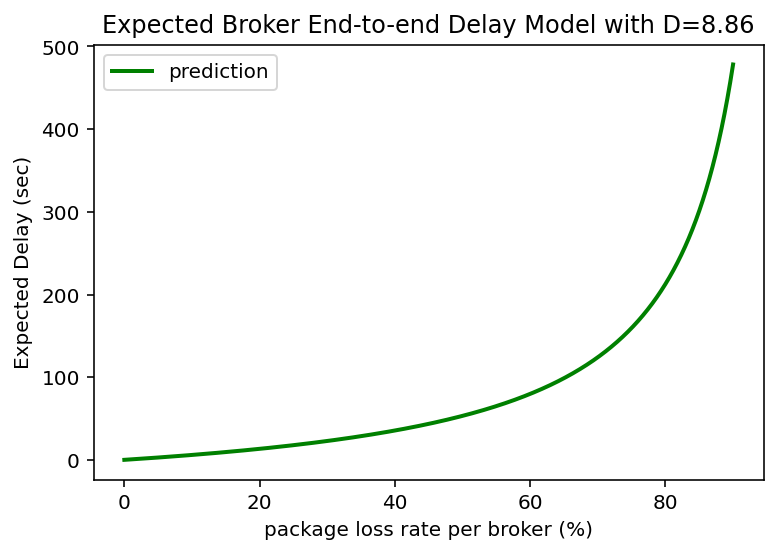

In [53]:
tc_x = np.arange(0.0, 90, 0.01)
d_0 = 0.04
D = 8.86 # includes d_0
delay_y_model = (d_0 + D * ((tc_x * 0.01) / (1- tc_x * 0.01))) * 6
line, = plt.plot(tc_x, delay_y_model, lw=2, color='green', label='prediction')
plt.xlabel('package loss rate per broker (%)')
plt.ylabel('Expected Delay (sec)')
plt.title("Expected Broker End-to-end Delay Model with D={}".format(D))
plt.legend()
# save_plot("delay/total_delay_model_no_data")

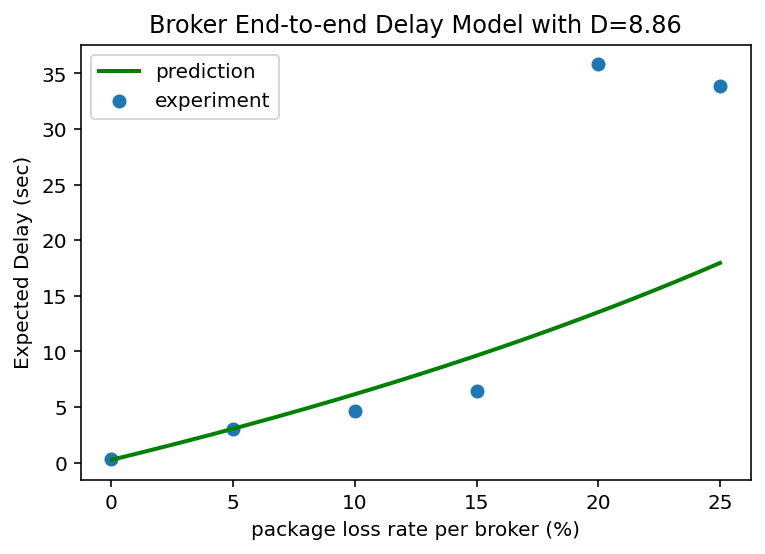

In [54]:
tc_x = np.arange(0.0, 25, 0.01)
d_0 = 0.04
D = 8.86 # includes d_0
delay_y_model = (d_0 + D * ((tc_x * 0.01) / (1- tc_x * 0.01))) * 6
line, = plt.plot(tc_x, delay_y_model, lw=2, color='green', label='prediction')
plt.scatter(tc_values, all_avg_delay, label='experiment')
plt.xlabel('package loss rate per broker (%)')
plt.ylabel('Expected Delay (sec)')
plt.title("Broker End-to-end Delay Model with D={}".format(D))
plt.legend()
# save_plot("delay/total_delay_model_with_data")

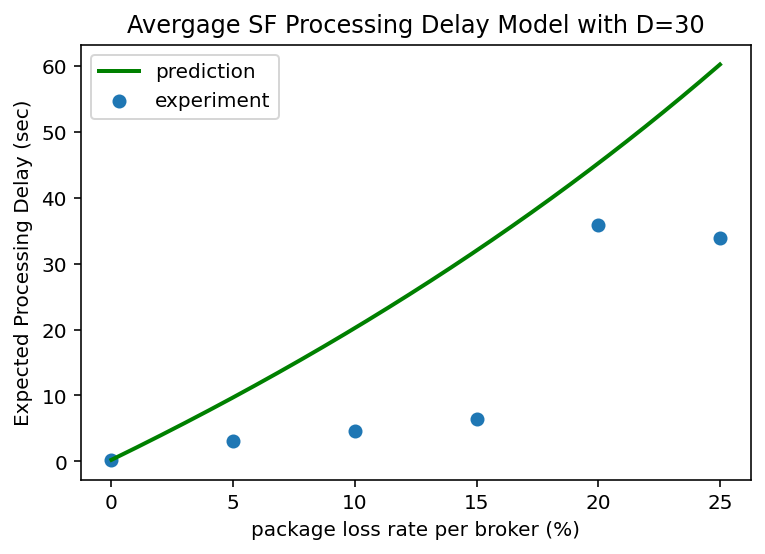

In [55]:
tc_x = np.arange(0.0, 25, 0.01)
d_0 = 0.04
D = 30 # changed fitted
delay_y_model = (d_0 + D * ((tc_x * 0.01) / (1- tc_x * 0.01))) * 6
line, = plt.plot(tc_x, delay_y_model, lw=2, color='green', label='prediction')
plt.scatter(tc_values, all_avg_delay, label='experiment')
plt.xlabel('package loss rate per broker (%)')
plt.ylabel('Expected Processing Delay (sec)')
plt.title("Avergage SF Processing Delay Model with D={}".format(D))
plt.legend()
# save_plot("delay/total_delay_model_with_correction")

### experimental area

[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b1.csv] Total no. of rows: 74870
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b2.csv] Total no. of rows: 12073
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b3.csv] Total no. of rows: 12296
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b4.csv] Total no. of rows: 12056
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b5.csv] Total no. of rows: 11309
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b6.csv] Total no. of rows: 11009
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b7.csv] Total no. of rows: 15814
[ LOG ] offset between dst=1.887866 and src=8.26913
configured forced_delay_time_offset = -1.3812640000000007
[ INFO ] packet loss = 1455, packet malformed = 0
[ INFO ] avg_delay = 4.628371084289438


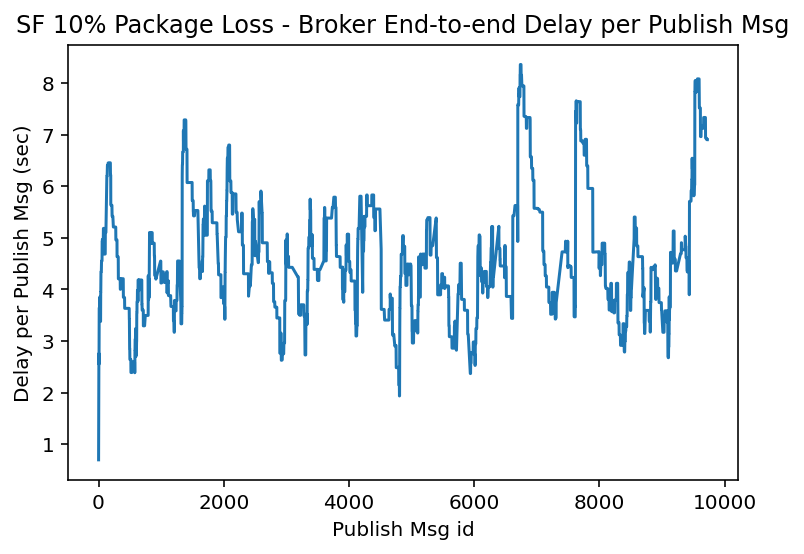

In [56]:
p_loss, p_mal, avg_delay = display_delay_graph("../broker_container/data1/delay_graph/tc-10/linear_sf/csv/", 
                                               [0,6], "SF 10% Package Loss -", -1, False)
# save_plot("delay/delay_plot_sf_tc-10")

[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b1.csv] Total no. of rows: 71059
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b2.csv] Total no. of rows: 7534
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b3.csv] Total no. of rows: 7275
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b4.csv] Total no. of rows: 6797
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b5.csv] Total no. of rows: 6243
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b6.csv] Total no. of rows: 6346
[../broker_container/data1/delay_graph/tc-15/linear_sf/csv/b7.csv] Total no. of rows: 9173
[ LOG ] offset between dst=2.210776 and src=3.899372
configured forced_delay_time_offset = 3.311404
[ INFO ] packet loss = 3957, packet malformed = 3
[ INFO ] avg_delay = 6.461226659843636


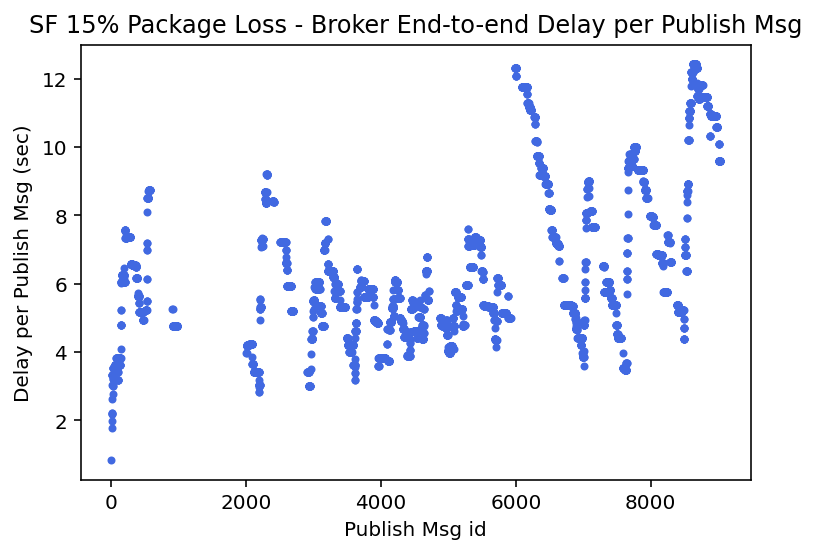

In [57]:
p_loss, p_mal, avg_delay = display_delay_graph("../broker_container/data1/delay_graph/tc-15/linear_sf/csv/", 
                                               [0,6], "SF 15% Package Loss -", -1, True)
# save_plot("delay/delay_plot_sf_tc-15_scatter")

[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b1.csv] Total no. of rows: 70316
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b2.csv] Total no. of rows: 2139
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b3.csv] Total no. of rows: 2599
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b4.csv] Total no. of rows: 2549
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b5.csv] Total no. of rows: 2226
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b6.csv] Total no. of rows: 2167
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b7.csv] Total no. of rows: 3743
[ LOG ] offset between dst=0.000376 and src=5.236171
configured forced_delay_time_offset = -0.23579499999999953
[ INFO ] packet loss = 5225, packet malformed = 3
[ INFO ] avg_delay = 33.8661562914013


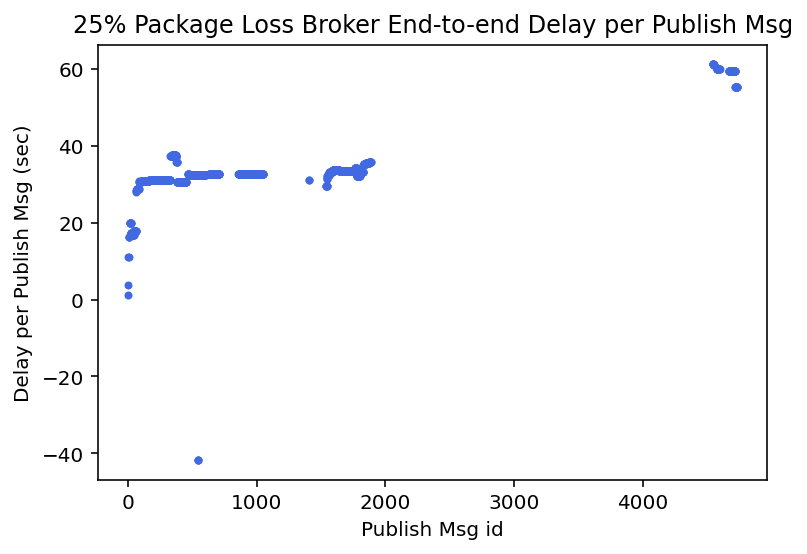

In [58]:
p_loss, p_mal, avg_delay = display_delay_graph("../broker_container/data1/delay_graph/tc-25/linear_sf/csv/", 
                                               [0,6], "25% Package Loss", -1, True)
# save_plot("delay/delay_plot_sf_tc-25_scatter")

[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b1.csv] Total no. of rows: 70316
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b2.csv] Total no. of rows: 2139
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b3.csv] Total no. of rows: 2599
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b4.csv] Total no. of rows: 2549
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b5.csv] Total no. of rows: 2226
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b6.csv] Total no. of rows: 2167
[../broker_container/data1/delay_graph/tc-25/linear_sf/csv/b7.csv] Total no. of rows: 3743
[ LOG ] offset between dst=0.000376 and src=5.236171
configured forced_delay_time_offset = -0.23579499999999953
[ INFO ] packet loss = 5225, packet malformed = 3
[ INFO ] avg_delay = 33.8661562914013


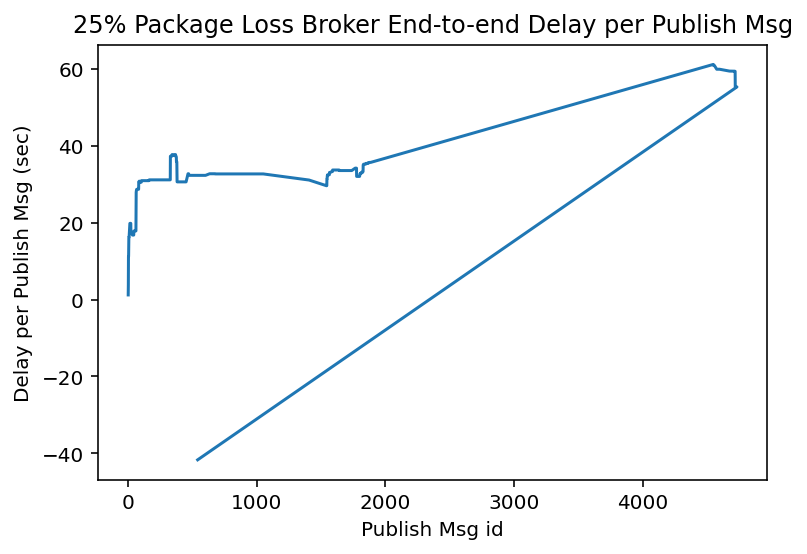

In [59]:
p_loss, p_mal, avg_delay = display_delay_graph("../broker_container/data1/delay_graph/tc-25/linear_sf/csv/", 
                                               [0,6], "25% Package Loss", -1, False)
# save_plot("delay/delay_plot_sf_tc-25")

[../broker_container/data1/delay_graph/tc-10/linear_pf/csv/b1.csv] Total no. of rows: 72316
[../broker_container/data1/delay_graph/tc-10/linear_pf/csv/b2.csv] Total no. of rows: 11487
[../broker_container/data1/delay_graph/tc-10/linear_pf/csv/b3.csv] Total no. of rows: 11222
[../broker_container/data1/delay_graph/tc-10/linear_pf/csv/b4.csv] Total no. of rows: 11137
[../broker_container/data1/delay_graph/tc-10/linear_pf/csv/b5.csv] Total no. of rows: 11338
[../broker_container/data1/delay_graph/tc-10/linear_pf/csv/b6.csv] Total no. of rows: 11484
[../broker_container/data1/delay_graph/tc-10/linear_pf/csv/b7.csv] Total no. of rows: 12577
[ LOG ] offset between dst=0.00028 and src=0.000751
configured forced_delay_time_offset = 4.999529
[ INFO ] packet loss = 1710, packet malformed = 0
[ INFO ] avg_delay = 4.552425901930001


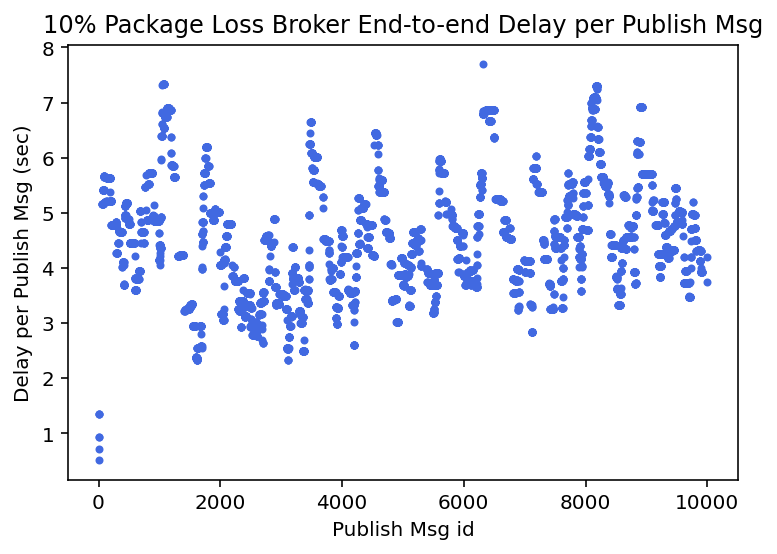

In [60]:
p_loss, p_mal, avg_delay = display_delay_graph("../broker_container/data1/delay_graph/tc-10/linear_pf/csv/", 
                                               [0,6], "10% Package Loss", -1, True)
# save_plot("delay/delay_plot_pf_tc-10")

### Intermediate Delays

In [61]:
# process_single(f_tmp, r_tmp, 1)
# @is_src = 1 means we are interested in broker->broker data. Otherwise, broker->client data
def delay_process_intermediate_single(fields, rows, broker_num, is_src = 1):
    src_filter = [brokers[broker_num]]
    intermediate_dst_filter = clients + brokers[1:broker_num+1] # must look forward
    print(intermediate_dst_filter, broker_num)
    # process data
    result = my_delay_filter(rows, src_filter, intermediate_dst_filter, 3)
    return result

'''
@all_data: consists of raw data in the form of [ (field, rows) ] 
@selected: specifies which data in @all_data to process, in the form of [ index_1, index_2, ... ] 
@dst_pos: an index which specifies the position of data that is broker->client
    takes in @all_data and processes the selected one specified at @selected
    returns a list of [ (processed_data) ]  for each data of type (field, data) in @all_data
'''
def delay_process_intermediate_all(all_data, selected):
    result = []
    for i in selected:
        fld, data = all_data[i]
        result.append(delay_process_intermediate_single(fld, data, i+1, 1))
    return result

"""
Processes intermediate delays, by looking at the time difference between PUB of two brokers
@delay_csv_dir: e.g. "../../delay_graph/tc-0/linear_pf/csv/"
@broker_pos: e.g. to compute the msg diff between broker 1 and 7, pass in [0,6]
"""
def display_intermediate_delay_graph(csv_dir, broker_pos, plot_base_name="", forced_delay_time_offset = -1, scatter = False):
    delay_csv_dir = csv_dir
    delay_files = my_init(delay_csv_dir)
    delay_all_raw_data = parse_num_delay_csv(delay_files)
    delay_all_data = delay_process_intermediate_all(delay_all_raw_data, broker_pos)
    start_pos = broker_pos[0]
    end_pos = broker_pos[-1]
    reset_find_msg_id_in_dst()
    if(forced_delay_time_offset == -1):
        forced_delay_time_offset = compute_src_dst_offset(delay_all_raw_data[start_pos][1], start_pos+1, 
                                               delay_all_raw_data[end_pos][1], end_pos+1)
    delay_x, delay_y = delay_compute_mgs_delay(delay_all_data[0], delay_all_data[1], forced_delay_time_offset)
    delay_plot_single(delay_x, delay_y, plot_base_name, scatter)
    print("packet loss = {}, packet malformed = {}".format(len(find_msg_id_in_dst.packet_loss), 
                                                           len(find_msg_id_in_dst.packet_malformed)))
    return (find_msg_id_in_dst.packet_loss, find_msg_id_in_dst.packet_malformed)

[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b1.csv] Total no. of rows: 74870
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b2.csv] Total no. of rows: 12073
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b3.csv] Total no. of rows: 12296
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b4.csv] Total no. of rows: 12056
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b5.csv] Total no. of rows: 11309
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b6.csv] Total no. of rows: 11009
[../broker_container/data1/delay_graph/tc-10/linear_sf/csv/b7.csv] Total no. of rows: 15814
['172.19.0.9', '172.19.0.10', '172.19.0.2', '172.19.0.3'] 2
['172.19.0.9', '172.19.0.10', '172.19.0.2'] 1
packet loss = 1143, packet malformed = 0


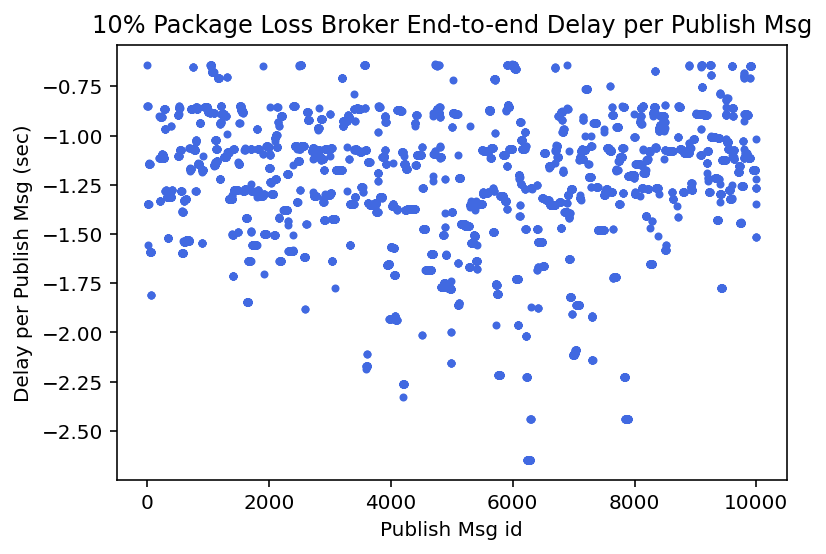

In [62]:
p_loss, p_mal = display_intermediate_delay_graph("../broker_container/data1/delay_graph/tc-10/linear_sf/csv/", 
                                                 [1,0], "10% Package Loss", 0, True)

In [63]:
p_loss

{6594,
 6,
 2072,
 2073,
 2074,
 2075,
 2076,
 2077,
 2078,
 2079,
 2080,
 2081,
 2082,
 6595,
 4723,
 8386,
 8230,
 8646,
 40,
 41,
 2095,
 8794,
 8387,
 6759,
 8252,
 6207,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 6333,
 6334,
 6335,
 6336,
 6337,
 6338,
 6339,
 6340,
 6341,

Since I cannot correctly figure out the time offset via Connect packet for intermediate brokers, this is difficult